In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import kagglehub
from pathlib import Path

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abcsds/pokemon")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pokemon


In [4]:
csv_files = list(Path(path).rglob("*.csv"))
df = pd.read_csv(csv_files[0])

In [6]:
df_clean = df.dropna()

#только числовые колонки
df_numeric = df_clean.select_dtypes(include='number')

# корреляция
correlation_matrix = df_numeric.corr()

target_col = 'Total'
correlations = correlation_matrix[target_col].drop(target_col).abs()
top2_features = correlations.sort_values(ascending=False).head(2).index.tolist()

print("Top 2 correlated features:", top2_features)

Top 2 correlated features: ['Attack', 'Sp. Atk']


Aici am luat cele 2 cu cele mai mare correlatie total cu numa coloanele cu numere

In [7]:
df_subset = df_numeric[top2_features + [target_col]]
X = df_subset[top2_features].values

In [17]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import numpy as np

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

models = {
    "Isolation Forest": IsolationForest(contamination=0.1, random_state=42),
    "OneClass SVM": OneClassSVM(nu=0.1, kernel="rbf", gamma='scale'),
    "Elliptic Envelope": EllipticEnvelope(contamination=0.1, random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=0.1)
}

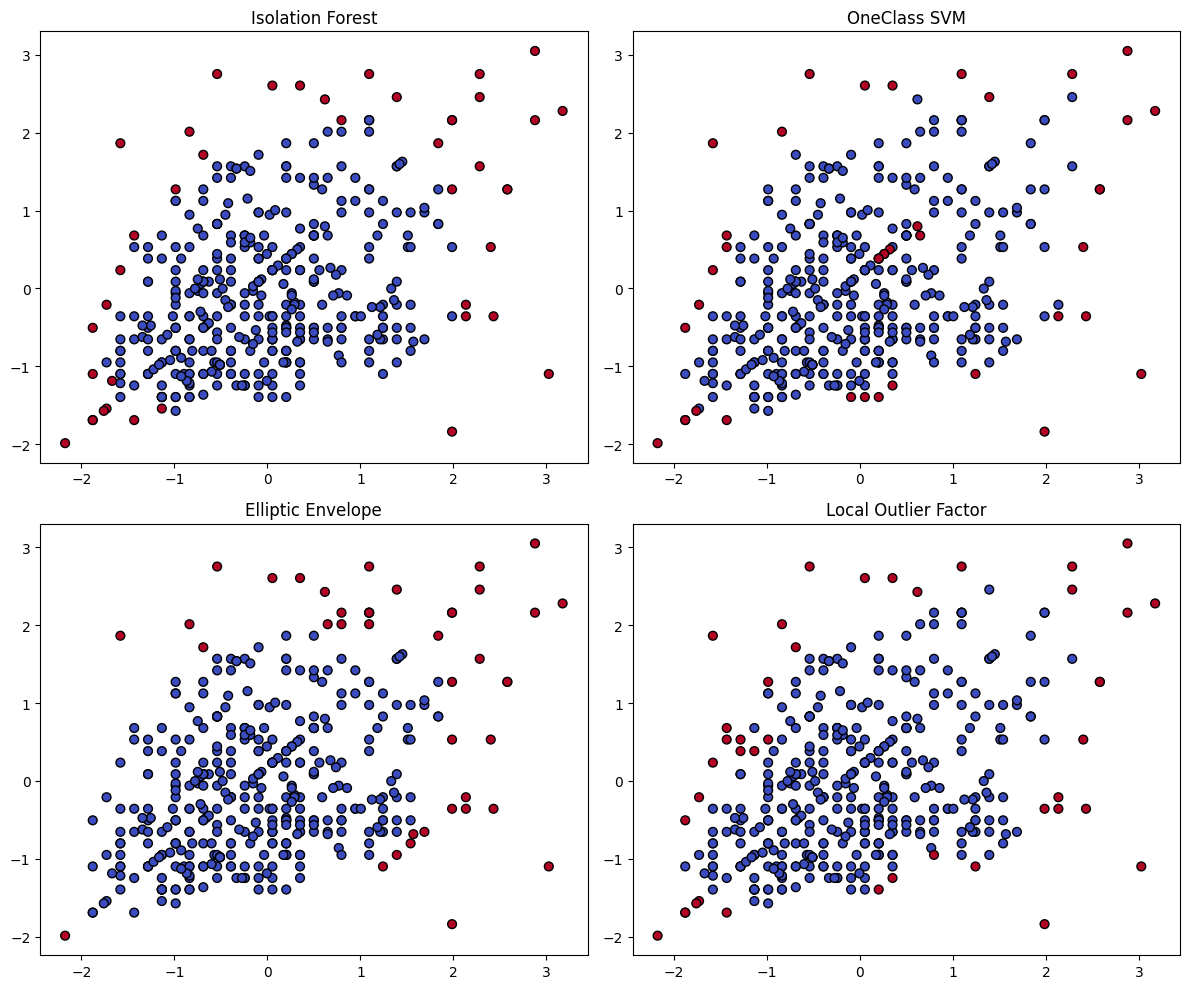

In [18]:
plt.figure(figsize=(12, 10))

for i, (name, model) in enumerate(models.items(), 1):
    if name == "Local Outlier Factor":
        y_pred = model.fit_predict(X_scaled)
    else:
        model.fit(X_scaled)
        y_pred = model.predict(X_scaled)

    y_pred = np.where(y_pred == -1, 1, 0)  # 1 - выброс, 0 - норм

    plt.subplot(2, 2, i)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_pred, cmap='coolwarm', edgecolors='k', s=40)
    plt.title(name)

plt.tight_layout()
plt.show()

Каждый график показывает, как алгоритм разделяет нормальные данные синие точки и выбросы красные. Есть алгоритмы более агрессивны - больше выбросов, а какие — более сдержанные.

Вывод Isolation Forest может быть чувствителен к плотности,
а Elliptic Envelope — к форме распределения (он предполагает, что данные - эллипсоидные)

In [20]:
contamination_values = np.linspace(0.01, 0.3, 15)
outlier_counts = {
    "Isolation Forest": [],
    "OneClass SVM": [],
    "Elliptic Envelope": [],
    "Local Outlier Factor": []
}

for cont in contamination_values:
    # Isolation Forest
    iso = IsolationForest(contamination=cont, random_state=42)
    iso.fit(X_scaled)
    preds = iso.predict(X_scaled)
    outlier_counts["Isolation Forest"].append(np.sum(preds == -1))

    # One-Class SVM
    svm = OneClassSVM(nu=cont, kernel="rbf", gamma='scale')
    preds = svm.fit_predict(X_scaled)
    outlier_counts["OneClass SVM"].append(np.sum(preds == -1))

    # Elliptic Envelope
    ell = EllipticEnvelope(contamination=cont, random_state=42)
    ell.fit(X_scaled)
    preds = ell.predict(X_scaled)
    outlier_counts["Elliptic Envelope"].append(np.sum(preds == -1))

    # Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=20, contamination=cont)
    preds = lof.fit_predict(X_scaled)
    outlier_counts["Local Outlier Factor"].append(np.sum(preds == -1))


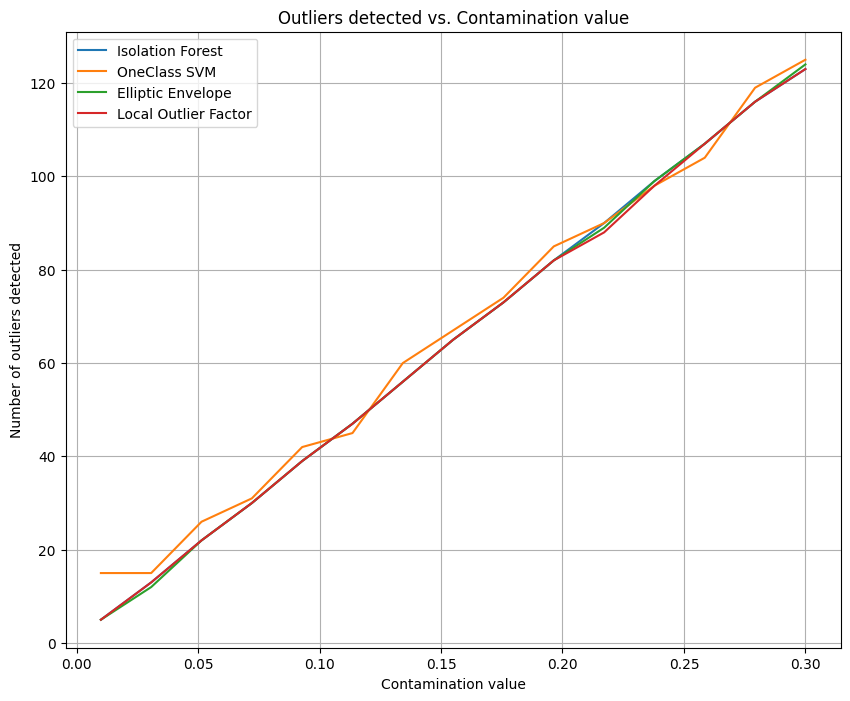

In [19]:
plt.figure(figsize=(10, 8))
for name, counts in outlier_counts.items():
    plt.plot(contamination_values, counts, label=name)

plt.xlabel("Contamination value")
plt.ylabel("Number of outliers detected")
plt.title("Outliers detected vs. Contamination value")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
for name, counts in outlier_counts.items():
    plt.plot(contamination_values, counts, label=name)

plt.xlabel("Contamination value")
plt.ylabel("Number of outliers detected")
plt.title("Outliers detected vs. Contamination value")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

X_full = df_numeric.drop(columns=[target_col])
y_full = df_numeric[target_col]


scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_full)


X_train, X_test, y_train, y_test = train_test_split(X_full_scaled, y_full, test_size=0.2, random_state=42)

def evaluate_models(X_tr, y_tr, X_te, y_te):
    results = {}

    lr = LinearRegression()
    lr.fit(X_tr, y_tr)
    y_pred_lr = lr.predict(X_te)
    results['LinearRegression'] = mean_squared_error(y_te, y_pred_lr, squared=False)

    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(X_tr, y_tr)
    y_pred_knn = knn.predict(X_te)
    results['KNN'] = mean_squared_error(y_te, y_pred_knn, squared=False)

    return results


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd


X_full = df_numeric.drop(columns=[target_col])
y_full = df_numeric[target_col]

scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_full)

X_train, X_test, y_train, y_test = train_test_split(X_full_scaled, y_full, test_size=0.2, random_state=42)


def evaluate_models(X_tr, y_tr, X_te, y_te):
    results = {}

    lr = LinearRegression()
    lr.fit(X_tr, y_tr)
    y_pred_lr = lr.predict(X_te)
    results['Linear Regression RMSE'] = np.sqrt(mean_squared_error(y_te, y_pred_lr))

    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(X_tr, y_tr)
    y_pred_knn = knn.predict(X_te)
    results['KNN RMSE'] = np.sqrt(mean_squared_error(y_te, y_pred_knn))

    return results


final_results = {}

# Базовая модель без удаления выбросов
final_results["No outlier removal"] = evaluate_models(X_train, y_train, X_test, y_test)


cleaning_models = {
    "Isolation Forest": IsolationForest(contamination=0.1, random_state=42),
    "OneClass SVM": OneClassSVM(nu=0.1, gamma='scale'),
    "Elliptic Envelope": EllipticEnvelope(contamination=0.1, random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=0.1)
}

for name, model in cleaning_models.items():
    if name == "Local Outlier Factor":
        y_pred = model.fit_predict(X_train)
    else:
        model.fit(X_train)
        y_pred = model.predict(X_train)

    mask = y_pred != -1
    X_train_clean = X_train[mask]
    y_train_clean = y_train[mask]

    final_results[name] = evaluate_models(X_train_clean, y_train_clean, X_test, y_test)


In [16]:
df_results = pd.DataFrame(final_results).T
df_results

,Linear Regression RMSE,KNN RMSE
No outlier removal,1.480455e-13,27.261810
Isolation Forest,2.029956e-13,30.440382
OneClass SVM,8.873305e-14,29.867466
Elliptic Envelope,1.301699e-13,28.957368
Local Outlier Factor,1.042648e-13,29.536785
